# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [126]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-molformer": ("HDBind+MolFormer", green_color_pal[4]),
    "hdbind-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
    "hdbind-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[9]),
#     "hdbind-rp-ecfp-1024-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-1024-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-1": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
# "selfies.atomwise": green_color_pal[4],
#     "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
#     "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
#     "HDC-MLP": green_color_pal[9],
#     "HDC-RF": green_color_pal[9],
    "Vina": ("Vina", "salmon"),
}


# model_order_list = [
#     ("hdbind-rp-molformer", )
#     ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
#     ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
#     ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
#     ("ecfp", "HDBind-ECFP"),
#     ("rp", "HDBind-ECFP+RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
# ]


# model_name_dict = {
#     "hdbind-rp-molformer": "HDBind+MolFormer"
#     "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
#     "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
#     "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
#     "ecfp": "HDBind-ECFP",
#     "rp": "HDBind-RPFP",
#     "rf": "RF",
#     "mlp": "MLP",
#     "Vina": "Vina",
#     "HDC-MLP": "HDC-MLP",
#     "HDC-RF": "HDC-RF"
# }

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [60]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, range_limit=10, multistep_initial_p=None, 
                      multistep_p_list=None, 
                      multistep_sklearn_model=None):
    
#     import pdb
#     pdb.set_trace()
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
                        }

    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        print(f"{model_name}-{dataset}: {len(model_tup)}\t {len(data_path_list)}")

        

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
#             with open(path, "rb") as handle:
#                 model_data_dict = pickle.load(handle)
            model_data_dict = pd.read_pickle(path)
            target = path.name.split(".")[1]
            
            print(target, path, model_name)


#             import ipdb
#             ipdb.set_trace()
            for seed in range(len(model_data_dict['trials'])):
                trial_dict = model_data_dict['trials'][seed]

                    
#                 with open(path, "wb") as handle:
#                     pickle.dump(model_data_dict, handle)
                
#                 with open(path, "rb") as handle:
#                     model_data_dict = pickle.load(handle)
#                 model_data_dict = pd.read_pkl(handle)
                    
                y_test = model_data_dict["y_test"]
#                 x_test = model_data_dict["x_test"]
                actives_database = sum(y_test)
                database_size = y_test.shape[0]
                
#                 eta = None 
                

#                 if model in ["rf", "mlp"]:


#                     for p in [.01, .1]:

#                         sklearn_model = model_data_dict[seed]["model"]

#                         y_score = sklearn_model.predict_proba(x_test)[:, 1]            
#                         y_pred = sklearn_model.predict(x_test)
#                         enrich = compute_enrichment_factor(sample_scores=y_score, 
#                                                 sample_labels=y_test,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)

                
#                         metrics = compute_metrics(y_pred=y_pred, y_score=y_score, y_true=y_test)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(p)
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])

                        
#                 elif model.lower() in ["hdc-rf", "hdc-mlp"]:

#                     sklearn_result_file = Path(f"{data_p}/{dataset.replace('-', '_')}.{target}.{multistep_sklearn_model}.None.{ngram_order}.pkl")

#                     with open(sklearn_result_file, "rb") as handle:
#                         sklearn_result_dict = pickle.load(handle)

#                     target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"

#                     hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                     hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)

# #                     # filter the data
#                     idxs = np.flip(np.argsort(hdc_conf_scores.squeeze().cpu().numpy(), kind="stable"))

                    
#                     sample_n = int(multistep_initial_p * y_test.shape[0])
#                     samp_idxs = idxs[:sample_n]
                    

#                     x_test_samp = x_test[samp_idxs]
#                     y_test_samp = y_test[samp_idxs]
                                            
    
#                     for p in multistep_p_list:

#                         sklearn_model = sklearn_result_dict[seed]["model"]
            
#                         sklearn_scores_samp = sklearn_model.predict_proba(x_test_samp)[:, 1]                        
            
#                         y_pred = sklearn_model.predict(x_test_samp)
#                         enrich = compute_enrichment_factor(sample_scores=sklearn_scores_samp, 
#                                                 sample_labels=y_test_samp,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)


#                         metrics = compute_metrics(y_pred=y_pred, y_score=sklearn_scores_samp, y_true=y_test_samp)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(round(multistep_initial_p * p, 2))
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])
                    

#                 else:                  
                    
#                 target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"
                
#                 hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                 hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)
                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    try:
#                         import pdb
#                         pdb.set_trace()
                        metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                                  y_score=hdc_conf_scores, 
                                                  y_true=model_data_dict["y_test"],
                                                 p=p)

    #                     model_metric_dict["model"].append(model)
                        model_metric_dict["target"].append(target)
    #                     model_metric_dict["enrich-1"].append(metrics["enrich-1"])
    #                     model_metric_dict["enrich-10"].append(metrics["enrich-10"])
#                         import pdb
#                         pdb.set_trace()
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
    #                     model_metric_dict["roc"].append(metrics["roc"])
                        model_metric_dict["model"].append(model_name)
                    except Exception as e:
                        print(e)

#                 #TODO: implement this 
#                 model_metric_dict["train_time"].append(train_time)

    return model_metric_dict
        


# VINA result

In [61]:
from pathlib import Path
def docking_main(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            
            # todo (10/18/23): is this valid?
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df

In [62]:
def compute_model_metric_df():
    
    model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)

    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    # model_metric_df

    #######
    vina_result = docking_main(nrows=None)
    vina_result
    ###########

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col=' scores/1'
    for target, target_df in vina_result.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)


    ##################
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
    model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
    return model_metric_df    


In [7]:

model_metric_df = compute_model_metric_df()


  0%|          | 0/7 [00:00<?, ?it/s]

hdbind-rp-molformer-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2.5.pkl hdbind-rp-molformer



  7%|▋         | 1/15 [00:17<04:06, 17.63s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1.5.pkl hdbind-rp-molformer



 13%|█▎        | 2/15 [00:25<02:33, 11.80s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago.5.pkl hdbind-rp-molformer



 20%|██        | 3/15 [00:25<01:18,  6.54s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant.5.pkl hdbind-rp-molformer



 27%|██▋       | 4/15 [00:25<00:44,  4.07s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1.5.pkl hdbind-rp-molformer



 33%|███▎      | 5/15 [00:47<01:43, 10.30s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA.5.pkl hdbind-rp-molformer



 40%|████      | 6/15 [01:02<01:48, 12.04s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1.5.pkl hdbind-rp-molformer



 47%|████▋     | 7/15 [01:23<01:58, 14.75s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A.5.pkl hdbind-rp-molformer



 53%|█████▎    | 8/15 [01:42<01:53, 16.26s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1.5.pkl hdbind-rp-molformer



 60%|██████    | 9/15 [01:45<01:12, 12.06s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1.5.pkl hdbind-rp-molformer



 67%|██████▋   | 10/15 [01:46<00:43,  8.76s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1.5.pkl hdbind-rp-molformer



 73%|███████▎  | 11/15 [02:02<00:43, 10.77s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2.5.pkl hdbind-rp-molformer



 80%|████████  | 12/15 [02:15<00:34, 11.60s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG.5.pkl hdbind-rp-molformer



 87%|████████▋ | 13/15 [02:15<00:16,  8.17s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53.5.pkl hdbind-rp-molformer



 93%|█████████▎| 14/15 [02:16<00:05,  5.77s/it]

lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR.5.pkl hdbind-rp-molformer



 14%|█▍        | 1/7 [02:36<15:36, 156.13s/it]

hdbind-ecfp-1024-1-100-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-ADRB2.5.pkl hdbind-ecfp-1024-1-100



  7%|▋         | 1/15 [00:15<03:40, 15.76s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-ALDH1.5.pkl hdbind-ecfp-1024-1-100



 13%|█▎        | 2/15 [00:22<02:15, 10.45s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-ESR1_ago.5.pkl hdbind-ecfp-1024-1-100



 20%|██        | 3/15 [00:22<01:09,  5.79s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-ESR1_ant.5.pkl hdbind-ecfp-1024-1-100



 27%|██▋       | 4/15 [00:22<00:39,  3.60s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-FEN1.5.pkl hdbind-ecfp-1024-1-100



 33%|███▎      | 5/15 [00:41<01:28,  8.81s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-GBA.5.pkl hdbind-ecfp-1024-1-100



 40%|████      | 6/15 [00:55<01:36, 10.77s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-IDH1.5.pkl hdbind-ecfp-1024-1-100



 47%|████▋     | 7/15 [01:13<01:45, 13.23s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-KAT2A.5.pkl hdbind-ecfp-1024-1-100



 53%|█████▎    | 8/15 [01:31<01:42, 14.64s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-MAPK1.5.pkl hdbind-ecfp-1024-1-100



 60%|██████    | 9/15 [01:34<01:05, 10.90s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-MTORC1.5.pkl hdbind-ecfp-1024-1-100



 67%|██████▋   | 10/15 [01:35<00:39,  7.94s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-OPRK1.5.pkl hdbind-ecfp-1024-1-100



 73%|███████▎  | 11/15 [01:48<00:37,  9.49s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-PKM2.5.pkl hdbind-ecfp-1024-1-100



 80%|████████  | 12/15 [02:00<00:30, 10.16s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-PPARG.5.pkl hdbind-ecfp-1024-1-100



 93%|█████████▎| 14/15 [02:00<00:05,  5.06s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-TP53.5.pkl hdbind-ecfp-1024-1-100
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100.lit-pcba-VDR.5.pkl hdbind-ecfp-1024-1-100



 29%|██▊       | 2/7 [04:54<12:09, 145.87s/it]

hdbind-ecfp-1024-1-1k-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-ADRB2.5.pkl hdbind-ecfp-1024-1-1k



  7%|▋         | 1/15 [00:18<04:15, 18.22s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-ALDH1.5.pkl hdbind-ecfp-1024-1-1k



 13%|█▎        | 2/15 [00:25<02:36, 12.04s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-ESR1_ago.5.pkl hdbind-ecfp-1024-1-1k



 20%|██        | 3/15 [00:26<01:20,  6.67s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-ESR1_ant.5.pkl hdbind-ecfp-1024-1-1k



 27%|██▋       | 4/15 [00:26<00:45,  4.14s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-FEN1.5.pkl hdbind-ecfp-1024-1-1k



 33%|███▎      | 5/15 [00:45<01:34,  9.42s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-GBA.5.pkl hdbind-ecfp-1024-1-1k



 40%|████      | 6/15 [01:00<01:41, 11.25s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-IDH1.5.pkl hdbind-ecfp-1024-1-1k



 47%|████▋     | 7/15 [01:18<01:49, 13.64s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-KAT2A.5.pkl hdbind-ecfp-1024-1-1k



 53%|█████▎    | 8/15 [01:36<01:44, 14.86s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-MAPK1.5.pkl hdbind-ecfp-1024-1-1k



 60%|██████    | 9/15 [01:38<01:06, 11.04s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-MTORC1.5.pkl hdbind-ecfp-1024-1-1k



 67%|██████▋   | 10/15 [01:40<00:40,  8.04s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-OPRK1.5.pkl hdbind-ecfp-1024-1-1k



 73%|███████▎  | 11/15 [01:53<00:38,  9.60s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-PKM2.5.pkl hdbind-ecfp-1024-1-1k



 80%|████████  | 12/15 [02:05<00:31, 10.35s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-PPARG.5.pkl hdbind-ecfp-1024-1-1k



 93%|█████████▎| 14/15 [02:05<00:05,  5.15s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-TP53.5.pkl hdbind-ecfp-1024-1-1k
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-1k.lit-pcba-VDR.5.pkl hdbind-ecfp-1024-1-1k



 43%|████▎     | 3/7 [07:18<09:39, 144.84s/it]

hdbind-rp-ecfp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-1



  7%|▋         | 1/15 [00:15<03:32, 15.15s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-1



 13%|█▎        | 2/15 [00:19<01:50,  8.52s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-1



 20%|██        | 3/15 [00:19<00:56,  4.75s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-1



 27%|██▋       | 4/15 [00:19<00:32,  2.96s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-1



 33%|███▎      | 5/15 [00:31<01:02,  6.29s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-1



 40%|████      | 6/15 [00:42<01:11,  7.89s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-1



 47%|████▋     | 7/15 [00:59<01:25, 10.72s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-1



 53%|█████▎    | 8/15 [01:11<01:18, 11.23s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-1



 60%|██████    | 9/15 [01:13<00:50,  8.39s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-1



 67%|██████▋   | 10/15 [01:14<00:30,  6.18s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-1



 73%|███████▎  | 11/15 [01:27<00:32,  8.21s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-1



 80%|████████  | 12/15 [01:36<00:24,  8.23s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-1



 93%|█████████▎| 14/15 [01:36<00:04,  4.11s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-1
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-1



 57%|█████▋    | 4/7 [09:06<06:31, 130.36s/it]

hdbind-ecfp-1024-1-100k-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-ADRB2.5.pkl hdbind-ecfp-1024-1-100k



  7%|▋         | 1/15 [00:16<03:45, 16.10s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-ALDH1.5.pkl hdbind-ecfp-1024-1-100k



 13%|█▎        | 2/15 [00:22<02:17, 10.58s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-ESR1_ago.5.pkl hdbind-ecfp-1024-1-100k



 20%|██        | 3/15 [00:23<01:10,  5.90s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-ESR1_ant.5.pkl hdbind-ecfp-1024-1-100k



 27%|██▋       | 4/15 [00:23<00:40,  3.70s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-FEN1.5.pkl hdbind-ecfp-1024-1-100k



 33%|███▎      | 5/15 [00:41<01:29,  8.99s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-GBA.5.pkl hdbind-ecfp-1024-1-100k



 40%|████      | 6/15 [00:56<01:38, 10.94s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-IDH1.5.pkl hdbind-ecfp-1024-1-100k



 47%|████▋     | 7/15 [01:15<01:48, 13.54s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-KAT2A.5.pkl hdbind-ecfp-1024-1-100k



 53%|█████▎    | 8/15 [01:33<01:44, 14.88s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-MAPK1.5.pkl hdbind-ecfp-1024-1-100k



 60%|██████    | 9/15 [01:36<01:07, 11.18s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-MTORC1.5.pkl hdbind-ecfp-1024-1-100k



 67%|██████▋   | 10/15 [01:37<00:40,  8.18s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-OPRK1.5.pkl hdbind-ecfp-1024-1-100k



 73%|███████▎  | 11/15 [01:51<00:39,  9.79s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-PKM2.5.pkl hdbind-ecfp-1024-1-100k



 80%|████████  | 12/15 [02:03<00:31, 10.44s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-PPARG.5.pkl hdbind-ecfp-1024-1-100k



 93%|█████████▎| 14/15 [02:03<00:05,  5.23s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-TP53.5.pkl hdbind-ecfp-1024-1-100k
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-ecfp-1024-1-100k.lit-pcba-VDR.5.pkl hdbind-ecfp-1024-1-100k



 71%|███████▏  | 5/7 [11:28<04:29, 134.50s/it]

molehd-bpe-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2.5.pkl molehd-bpe



  7%|▋         | 1/15 [00:15<03:32, 15.18s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1.5.pkl molehd-bpe



 13%|█▎        | 2/15 [00:21<02:11, 10.09s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago.5.pkl molehd-bpe



 20%|██        | 3/15 [00:21<01:07,  5.60s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant.5.pkl molehd-bpe



 27%|██▋       | 4/15 [00:22<00:38,  3.48s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1.5.pkl molehd-bpe



 33%|███▎      | 5/15 [00:40<01:26,  8.68s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA.5.pkl molehd-bpe



 40%|████      | 6/15 [00:55<01:37, 10.83s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1.5.pkl molehd-bpe



 47%|████▋     | 7/15 [01:15<01:52, 14.08s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A.5.pkl molehd-bpe



 53%|█████▎    | 8/15 [01:33<01:46, 15.27s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1.5.pkl molehd-bpe



 60%|██████    | 9/15 [01:36<01:07, 11.30s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1.5.pkl molehd-bpe



 67%|██████▋   | 10/15 [01:37<00:41,  8.22s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1.5.pkl molehd-bpe



 73%|███████▎  | 11/15 [01:50<00:38,  9.69s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2.5.pkl molehd-bpe



 80%|████████  | 12/15 [02:02<00:30, 10.33s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG.5.pkl molehd-bpe



 93%|█████████▎| 14/15 [02:02<00:05,  5.14s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53.5.pkl molehd-bpe
lit-pcba-VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR.5.pkl molehd-bpe



 86%|████████▌ | 6/7 [13:49<02:16, 136.57s/it]

mlp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2.5.pkl mlp-1024-1



  7%|▋         | 1/15 [00:47<11:03, 47.37s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1.5.pkl mlp-1024-1



 13%|█▎        | 2/15 [01:14<07:42, 35.59s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago.5.pkl mlp-1024-1



 20%|██        | 3/15 [01:15<03:56, 19.68s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant.5.pkl mlp-1024-1



 27%|██▋       | 4/15 [01:16<02:13, 12.16s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1.5.pkl mlp-1024-1



 33%|███▎      | 5/15 [02:26<05:31, 33.13s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA.5.pkl mlp-1024-1



 40%|████      | 6/15 [03:24<06:14, 41.61s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1.5.pkl mlp-1024-1



 47%|████▋     | 7/15 [04:22<06:16, 47.03s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A.5.pkl mlp-1024-1



 53%|█████▎    | 8/15 [04:33<04:09, 35.58s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1.5.pkl mlp-1024-1



 60%|██████    | 9/15 [04:44<02:46, 27.83s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1.5.pkl mlp-1024-1



 67%|██████▋   | 10/15 [04:49<01:44, 20.90s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1.5.pkl mlp-1024-1



 73%|███████▎  | 11/15 [05:25<01:42, 25.51s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2.5.pkl mlp-1024-1



 80%|████████  | 12/15 [06:14<01:37, 32.46s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG.5.pkl mlp-1024-1



 87%|████████▋ | 13/15 [06:14<00:45, 22.84s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53.5.pkl mlp-1024-1



 93%|█████████▎| 14/15 [06:15<00:16, 16.13s/it]

lit-pcba-VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR.5.pkl mlp-1024-1



  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:04,  3.18it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:03,  3.75it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:00<00:01,  5.65it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 47%|████▋     | 7/15 [00:01<00:01,  5.47it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 67%|██████▋   | 10/15 [00:01<00:00,  7.71it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv


 80%|████████  | 12/15 [00:01<00:00,  8.12it/s]

12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


 87%|████████▋ | 13/15 [00:02<00:00,  7.12it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


In [8]:
model_metric_df["model"]

0     hdbind-rp-molformer
1     hdbind-rp-molformer
2     hdbind-rp-molformer
3     hdbind-rp-molformer
4     hdbind-rp-molformer
             ...         
25                   Vina
26                   Vina
27                   Vina
28                   Vina
29                   Vina
Name: model, Length: 2130, dtype: object

In [9]:
(model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [127]:
def make_box_plot(enrich_1_df, enrich_10_df):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.boxplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
#     sns.boxplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich.png", dpi=600, bbox_inches="tight")

#     return enrich_f

In [128]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
grp_df = grp_df.sort_values(by="model")


In [129]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
29,Vina,VDR,0.1,1.052632
27,Vina,TP53,0.1,1.593379
25,Vina,PPARG,0.1,1.110483
23,Vina,PKM2,0.1,1.824729
19,Vina,MTORC1,0.1,0.833031
...,...,...,...,...
215,molehd-bpe,lit-pcba-ESR1_ago,0.1,0.000000
213,molehd-bpe,lit-pcba-ALDH1,0.1,2.009154
211,molehd-bpe,lit-pcba-ADRB2,0.1,0.000000
223,molehd-bpe,lit-pcba-IDH1,0.1,3.499691


In [130]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ADRB2,0.01,0.000000
28,Vina,VDR,0.01,1.315071
26,Vina,TP53,0.01,0.000000
24,Vina,PPARG,0.01,0.000000
22,Vina,PKM2,0.01,2.188966
...,...,...,...,...
216,molehd-bpe,lit-pcba-ESR1_ant,0.01,22.793787
214,molehd-bpe,lit-pcba-ESR1_ago,0.01,0.000000
212,molehd-bpe,lit-pcba-ALDH1,0.01,3.318849
210,molehd-bpe,lit-pcba-ADRB2,0.01,0.000000


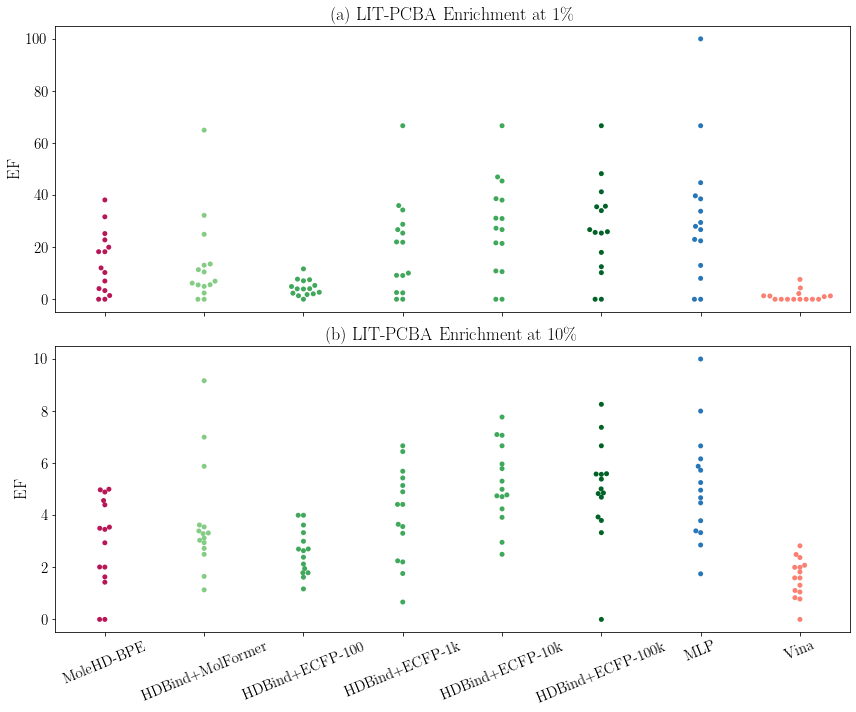

In [131]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

- should add the average EF (median?) to the labels on the horizontal axis
- scale the point size by standard deviation?
- standard scale the molformer embeddings?

In [43]:
def timing_plot(input_tup_list:list, dataset:str):
    
    
    f, ax = plt.subplots(1, 1, figsize=(12,10))
    
    df_dict = {"target": [], "model": [], "time": [], "format_name": []}
    for model_name, format_name in input_tup_list:
        
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        
        for path in data_path_list:
            with open(path, "rb") as handle:
                data = pickle.load(handle)
                
                test_time_list = []
                for i in range(10):
                    df_dict["time"].append(data["trials"][i]["test_time"]/data["y_test"].shape[0])
                    df_dict["target"].append(path.name)
                    df_dict["model"].append(model_name)
                    df_dict["format_name"].append(format_name)
                    

    df = pd.DataFrame(df_dict)
    xlabels = (df.groupby(["model", "format_name"]).median().reset_index()["format_name"]).values.tolist()
#     import pdb
#     pdb.set_trace()
    sns.swarmplot(data=df.groupby(["target", "model", "format_name"]).median().reset_index(),
                  order=[x for x in model_dict.keys()],
                  x="model", y="time", ax=ax)

    ax.tick_params(axis="x", labelrotation=22.5)
    ax.set_yscale("log")
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels = [x[1] for x in input_tup_list]
    ax.set_xticklabels(xlabels)
    
    f.savefig("lit-pcba-timing.png", dpi=600, bbox_inches="tight")
    
    return df
    

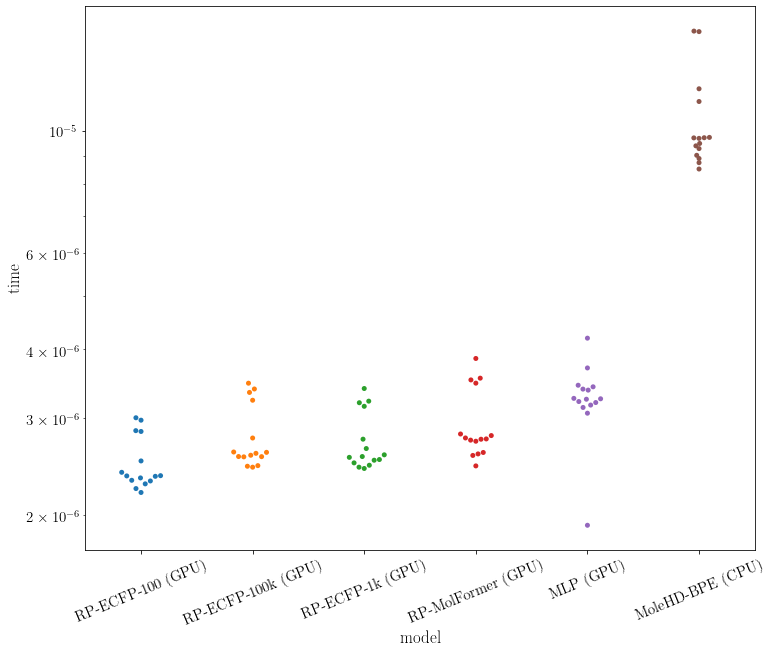

In [16]:
time_df = timing_plot([("mlp-1024-1", "MLP (GPU)"),
            ("hdbind-rp-molformer", "RP-MolFormer (GPU)"),
            ("molehd-bpe", "MoleHD-BPE (CPU)"),
            ("hdbind-ecfp-1024-1-100", "RP-ECFP-100 (GPU)"),
                      ("hdbind-ecfp-1024-1-1k", "RP-ECFP-1k (GPU)"),
                      ("hdbind-ecfp-1024-1-100k", "RP-ECFP-100k (GPU)")], 
                      dataset="lit-pcba")

In [17]:
avg_times = time_df.groupby(["model"]).mean()["time"].reset_index()
# avg_times.reset_index()

In [18]:
avg_times["time"][0], avg_times["model"][0]

(2.464742463662965e-06, 'hdbind-ecfp-1024-1-100')

In [19]:
avg_times["time"][1], avg_times["model"][1]

(2.7831767629267104e-06, 'hdbind-ecfp-1024-1-100k')

In [20]:
avg_times["time"][2], avg_times["model"][2]

(2.700661204010133e-06, 'hdbind-ecfp-1024-1-1k')

In [21]:
avg_times["time"][3], avg_times["model"][3]

(2.895931704911038e-06, 'hdbind-rp-molformer')

In [22]:
avg_times["time"][4], avg_times["model"][4]

(3.2678669578548485e-06, 'mlp-1024-1')

In [23]:
avg_times["time"][5], avg_times["model"][5]

(1.0359372603512413e-05, 'molehd-bpe')

---

In [24]:
100 * abs( avg_times["time"][0] - avg_times["time"][4])/(avg_times["time"][4])

24.57641343878592

In [25]:
avg_times["time"][4] / avg_times["time"][0]

1.3258451972293788

In [26]:
avg_times["time"][5] / avg_times["time"][0]

4.203024354973332

In [27]:
avg_times["time"][0] / avg_times["time"][1]

0.8855860312196309

- theres way more parameters in the hdbind-rp-molformer as compared to the mlp
- (1024 * 10000 = 10.24M parameters)
- (
- can D go higher? a .85x slow down from 100 to 10000 seems pretty small, there also seems to be a considerable increase in accuracy when pushing D higher...